In [163]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path
import warnings
import psycopg2
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import sys
import pickle
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import chi2_contingency 
from yellowbrick.classifier import ROCAUC
sys.path.insert(0, os.path.realpath('..\..\src'))
from database.database_config import DB_NAME, DB_HOST, DB_USER, DB_PASSWORD

In [2]:
#testing connecting to database and getting back data
db = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}")
conn = db.connect()

In [3]:
SQL = """
select
	match_id,
	mf.date_id,
	mf.venue_id,
	mf.referee_id,
	home_team_id as home_id,
	away_team_id as away_id,
	attendance,
    match_week,
	xg_home,
	xg_away,
	home_goal,
	away_goal,
	home_captain_name,
	away_captain_name,
	home_formation,
	away_formation,
	home_possession,
	away_possession,
	home_shots,
	home_shots_on_target,
	home_distance,
	home_freekicks,
	home_penalty_kicks,
	home_touches,
	home_touches_att_pen,
	home_touches_def_pen,
	home_touches_def_third,
	home_touches_mid_third,
	home_touches_att_third,
	home_touches_live,
	home_dribbles_success,
	home_dribbles_att,
	home_dribbles_mis,
	home_dribbles_dis,
	home_receiving_rec,
	home_receiving_prog,
	away_shots,
	away_shots_on_target,
	away_distance,
	away_freekicks,
	away_penalty_kicks,
	away_touches,
	away_touches_att_pen,
	away_touches_def_pen,
	away_touches_def_third,
	away_touches_mid_third,
	away_touches_att_third,
	away_touches_live,
	away_dribbles_success,
	away_dribbles_att,
	away_dribbles_mis,
	away_dribbles_dis,
	away_receiving_rec,
	away_receiving_prog,
	match_result,
	ht.team_name as home_team,
	aw.team_name as away_team,
	md."_date_",
	md."_time_" ,
	md."_day_",
	extract(MONTH from md."_date_") AS month,
	extract(DAY from md."_date_") AS day_of_month,
	extract(DOW from md."_date_") AS day_of_week,
	extract(YEAR from md."_date_") AS year,
	extract(HOUR from md."_time_") AS hour,
	extract(MINUTE from md."_time_") AS minute,
    extract(SECOND from md."_time_") AS second,
	mr.referee_name,
	mv.venue_name
from
	laliga_wh.match_facts mf
inner join laliga_wh.match_teams ht 
on
	ht.team_id = mf.home_team_id
inner join laliga_wh.match_teams aw 
on
	aw.team_id = mf.away_team_id
inner join laliga_wh.match_dates md 
on
	md.date_id = mf.date_id
inner join laliga_wh.match_referees mr 
on
	mr.referee_id = mf.referee_id
inner join laliga_wh.match_venues mv 
on
	mv.venue_id = mf.venue_id
"""

In [4]:
match_df = pd.read_sql(SQL, con=conn)
match_df.head()

,match_id,date_id,venue_id,referee_id,home_id,away_id,attendance,match_week,xg_home,xg_away,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1,1,13,23,18,1,9231.0,1,1.3,1.1,...,Fri,8.0,18.0,5.0,2017.0,20.0,15.0,0.0,José Munuera,Estadio Municipal de Butarque
1,2,2,25,19,27,17,35971.0,1,1.4,0.2,...,Fri,8.0,18.0,5.0,2017.0,22.0,15.0,0.0,Jesús Gil,Estadio de Mestalla
2,3,3,22,7,7,25,16961.0,1,1.8,2.1,...,Sat,8.0,19.0,6.0,2017.0,18.0,15.0,0.0,Antonio Matéu Lahoz,Estadio de Balaídos
3,4,4,3,25,13,4,11511.0,1,2.2,0.7,...,Sat,8.0,19.0,6.0,2017.0,20.0,15.0,0.0,Juan Martínez,Estadi Municipal de Montilivi
4,5,5,18,4,26,11,30487.0,1,2.4,1.3,...,Sat,8.0,19.0,6.0,2017.0,22.0,15.0,0.0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán


In [5]:
# Drop id columns
match_results = match_df.iloc[:,6:]

In [6]:
#Cehck the columns quick
# for i,v in match_results.dtypes.iteritems():
#     print(i, v)

In [7]:
match_results[match_results['attendance'].isnull()]

,attendance,match_week,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
66,NaN,7,4.0,0.7,3,0,Lionel Messi,Jonathan Viera,4-4-2,4-2-3-1,...,Sun,10.0,1.0,0.0,2017.0,16.0,15.0,0.0,José Munuera,Camp Nou
1029,NaN,24,2.0,1.2,1,2,Gonzalo Escalante,Mikel Oyarzabal,4-2-3-1,4-2-3-1,...,Tue,3.0,10.0,2.0,2020.0,20.0,0.0,0.0,David Medié,Estadio Municipal de Ipurúa
1030,NaN,28,1.7,0.5,2,0,Jesús Navas,Sergio Canales,4-3-3,4-3-3,...,Thu,6.0,11.0,4.0,2020.0,22.0,0.0,0.0,Antonio Matéu Lahoz,Estadio Ramón Sánchez Pizjuán
1031,NaN,28,2.3,0.6,2,1,Víctor Díaz,Jorge Molina,4-2-3-1,4-4-2,...,Fri,6.0,12.0,5.0,2020.0,19.0,30.0,0.0,David Medié,Estadio Nuevo Los Cármenes
1032,NaN,28,1.0,1.4,1,1,Daniel Parejo,José Luis Morales,4-4-2,4-4-2,...,Fri,6.0,12.0,5.0,2020.0,22.0,0.0,0.0,Alberola Rojas,Estadio de Mestalla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,NaN,38,1.2,0.6,2,1,Karim Benzema,Mario Gaspar,4-3-3,4-4-2,...,Sat,5.0,22.0,6.0,2021.0,18.0,0.0,0.0,José Luis Munuera,Estadio Alfredo Di Stéfano
1517,NaN,38,1.1,1.4,1,2,Jordi Masip,Koke,4-4-2,4-3-3,...,Sat,5.0,22.0,6.0,2021.0,18.0,0.0,0.0,José Sánchez,Estadio Municipal José Zorrilla
1518,NaN,38,0.4,0.6,0,0,Germán Sánchez,Djené,5-4-1,4-4-1-1,...,Sun,5.0,23.0,0.0,2021.0,18.0,30.0,0.0,David Medié,Estadio Nuevo Los Cármenes
1519,NaN,38,0.4,1.1,1,0,Sergio Escudero,Manu García,4-3-3,4-3-3,...,Sun,5.0,23.0,0.0,2021.0,21.0,0.0,0.0,Isidro Díaz de Mera,Estadio Ramón Sánchez Pizjuán


In [8]:
# Fix data types for certain columns
match_results['attendance'] = match_results['attendance'].astype(pd.Int64Dtype())
match_results['_date_'] = pd.to_datetime(match_results['_date_'])
# int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
# float_columns = match_results.select_dtypes(include=['float64']).columns
# match_results[int_columns] = match_results[int_columns].astype('int64')
# match_results[float_columns] = match_results[float_columns].astype('np.float32')
match_results['month'] = match_results['month'].astype('int64')
match_results['day_of_month'] = match_results['day_of_month'].astype('int64')
match_results['day_of_week'] = match_results['day_of_week'].astype('int64')
match_results['year'] = match_results['year'].astype('int64')
match_results['hour'] = match_results['hour'].astype('int64')
match_results['minute'] = match_results['minute'].astype('int64')
match_results['second'] = match_results['second'].astype('int64')
match_results.drop(['_day_', '_time_'], axis = 1, inplace = True) # Not needed as we created numerical columns for the date components

In [9]:
match_results['home_formation'].value_counts()

4-4-2         695
4-2-3-1       391
4-3-3         347
4-1-4-1       124
3-4-3          84
3-5-2          67
5-3-2          64
4-1-3-2        45
4-4-1-1        44
3-1-4-2        38
4-1-2-1-2◆     32
5-4-1          26
3-4-1-2        16
4-3-1-2        12
4-5-1          11
3-5-1-1         5
4-2-2-2         5
4-3-2-1         2
3-4-3◆          1
4-2-4-0         1
Name: home_formation, dtype: int64

In [10]:
# Clean up formations
match_results['home_formation'] = match_results['home_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-1-2-1-2◆': '4-1-2-1-2'})
match_results['away_formation'] = match_results['away_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-3-2-1◆':'4-3-2-1', '4-1-2-1-2◆': '4-1-2-1-2'})

# Time Frame Extraction
Gather only data up until last season

In [11]:
print('Start Date: ', min(match_results._date_.dt.date))
print('End Date: ', max(match_results._date_.dt.date))

Start Date:  2017-08-18
End Date:  2022-10-24


In [12]:
start_date = '2017-08-01'
end_date = '2022-05-30'
mask = (match_results['_date_'] > start_date) & (match_results['_date_'] <= end_date)
match_results = match_results.loc[mask]

# Preprocessing

In [13]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	488
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
_date_	0
month	0
day_of_month	0
d

In [14]:
# Drop attendance. We have MCAR data here and not recommended to keep it
# Drop _date_. We already split this into numerical components
# Fill other columns with 1 or 2 missing values with median
match_results.drop(['attendance', '_date_', 'match_week'], axis = 1, inplace = True)
match_results[ 'away_distance'] = match_results[ 'away_distance'].fillna(match_results['away_distance'].median())
int_columns = match_results.select_dtypes(include=['Int64', 'int64']).columns
match_results[int_columns] = match_results[int_columns].astype('int64')

In [15]:
# Count number of missing values - check again
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_mis	0
home_dribbles_dis	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	0
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbles_success	0
away_dribbles_att	0
away_dribbles_mis	0
away_dribbles_dis	0
away_receiving_rec	0
away_receiving_prog	0
match_result	0
home_team	0
away_team	0
month	0
day_of_month	0
day_of_week	0
year	0
hour	0
minute	0
s

In [16]:
# One hot encode
match_results_encode = pd.get_dummies(match_results, columns = ['home_captain_name', 'away_captain_name', 'home_formation', 'away_formation',
                                                                'home_team', 'away_team', 'referee_name', 'venue_name'])

In [17]:
match_results_encode.head()

,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,1.3,1.1,1,0,53.0,47.0,14,3,22.0,2,...,0,0,0,0,0,0,0,0,0,0
1,1.4,0.2,1,0,47.0,53.0,22,6,17.0,2,...,0,0,0,0,1,0,0,0,0,0
2,1.8,2.1,2,3,53.0,47.0,16,5,17.4,1,...,0,1,0,0,0,0,0,0,0,0
3,2.2,0.7,2,2,52.0,48.0,13,6,18.2,1,...,0,0,0,0,0,0,0,0,0,0
4,2.4,1.3,1,1,62.0,38.0,9,4,11.5,0,...,0,0,0,0,0,0,0,0,0,0


# Explore the Data

## Check match results

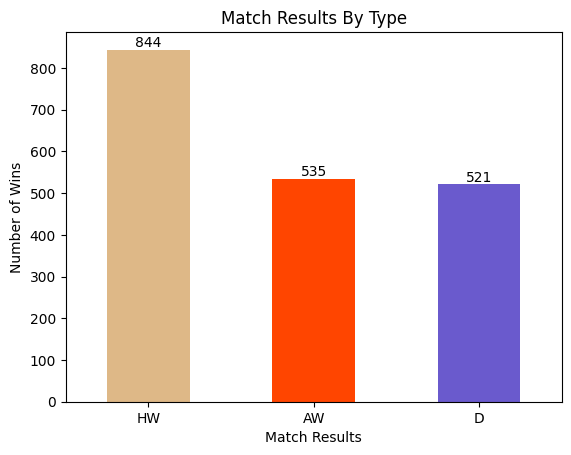

In [18]:
ax = match_results_encode['match_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot =0, 
                                                              xlabel = "Match Results", ylabel = "Number of Wins", title = "Match Results By Type")
ax.plot()
ax.bar_label(ax.containers[0])
plt.show()

We see that there are a high number of away wins. There is possibly a home field advantage present in our data

## Check El Clasico match results

In [19]:
# get all records with El Clasico
clasico_matches = match_results_encode[((match_results_encode['home_team_Barcelona'] == 1) & (match_results_encode['away_team_Real Madrid'] == 1)) |
                                       ((match_results_encode['home_team_Real Madrid'] == 1) & (match_results_encode['away_team_Barcelona'] == 1))]

In [20]:
#Encode the match results
def create_clasico_result(row):
    if row.match_result == 'HW' and row['home_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'AW' and row['away_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'HW' and row['home_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    elif row.match_result == 'AW' and row['away_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    else:
        return 'Draw'
    
clasico_matches['clasico_result'] = clasico_matches.apply(create_clasico_result, axis =1)

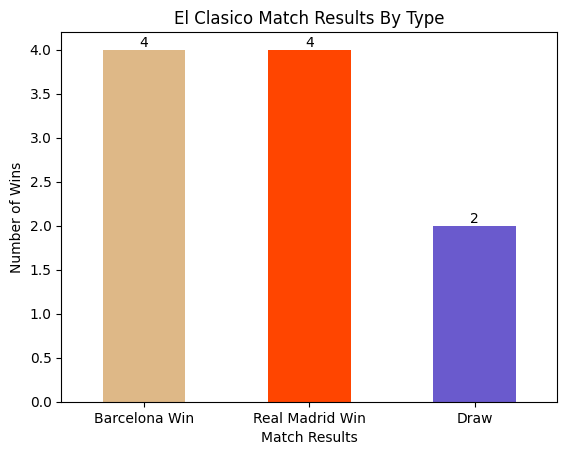

In [21]:
ax = clasico_matches['clasico_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot = 0,
                                                          xlabel = "Match Results", ylabel = "Number of Wins", title = "El Clasico Match Results By Type")
ax.plot()
ax.bar_label(ax.containers[0])
plt.show()

We see here that matches are fairly even between FC Barcelona and Real Madrid the past 4 seasons

## Check our numerical distributions

In [22]:
#Select all our numerical columns
numerical_columns = match_results_encode.select_dtypes(include=['Int64', 'int64', 'float64', 'int32'])

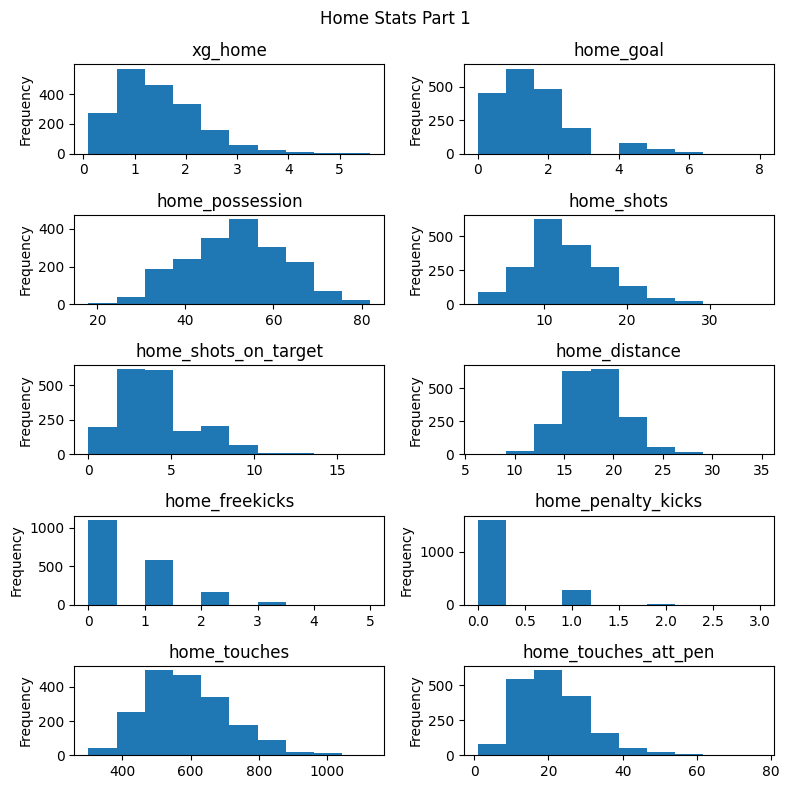

In [23]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_home'].plot.hist(ax =ax1[0,0], title = 'xg_home')
numerical_columns['home_goal'].plot.hist(ax =ax1[0,1], title = 'home_goal')
numerical_columns['home_possession'].plot.hist(ax =ax1[1,0], title = 'home_possession')
numerical_columns['home_shots'].plot.hist(ax =ax1[1,1], title = 'home_shots')
numerical_columns['home_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'home_shots_on_target')
numerical_columns['home_distance'].plot.hist(ax =ax1[2,1], title = 'home_distance')
numerical_columns['home_freekicks'].plot.hist(ax =ax1[3,0], title = 'home_freekicks')
numerical_columns['home_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'home_penalty_kicks')
numerical_columns['home_touches'].plot.hist(ax =ax1[4,0], title = 'home_touches')
numerical_columns['home_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'home_touches_att_pen')

plt.suptitle('Home Stats Part 1')
plt.tight_layout()
plt.show()

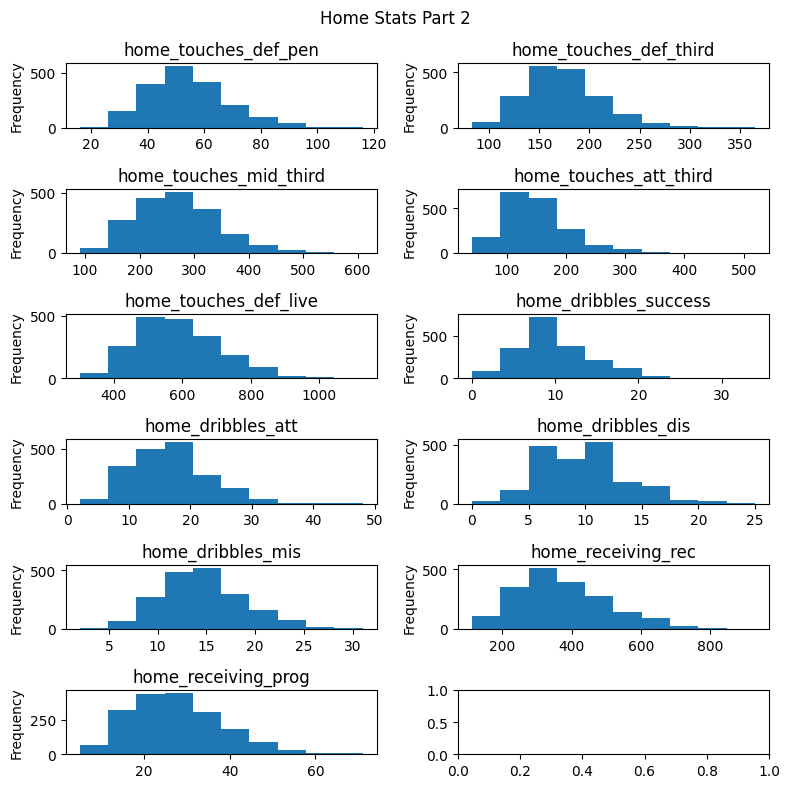

In [24]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['home_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'home_touches_def_pen')
numerical_columns['home_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'home_touches_def_third')
numerical_columns['home_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'home_touches_mid_third')
numerical_columns['home_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'home_touches_att_third')
numerical_columns['home_touches_live'].plot.hist(ax =ax2[2,0], title = 'home_touches_def_live')
numerical_columns['home_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'home_dribbles_success')
numerical_columns['home_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'home_dribbles_att')
numerical_columns['home_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'home_dribbles_dis')
numerical_columns['home_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'home_dribbles_mis')
numerical_columns['home_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'home_receiving_rec')
numerical_columns['home_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'home_receiving_prog')

plt.suptitle('Home Stats Part 2')
plt.tight_layout()
plt.show()

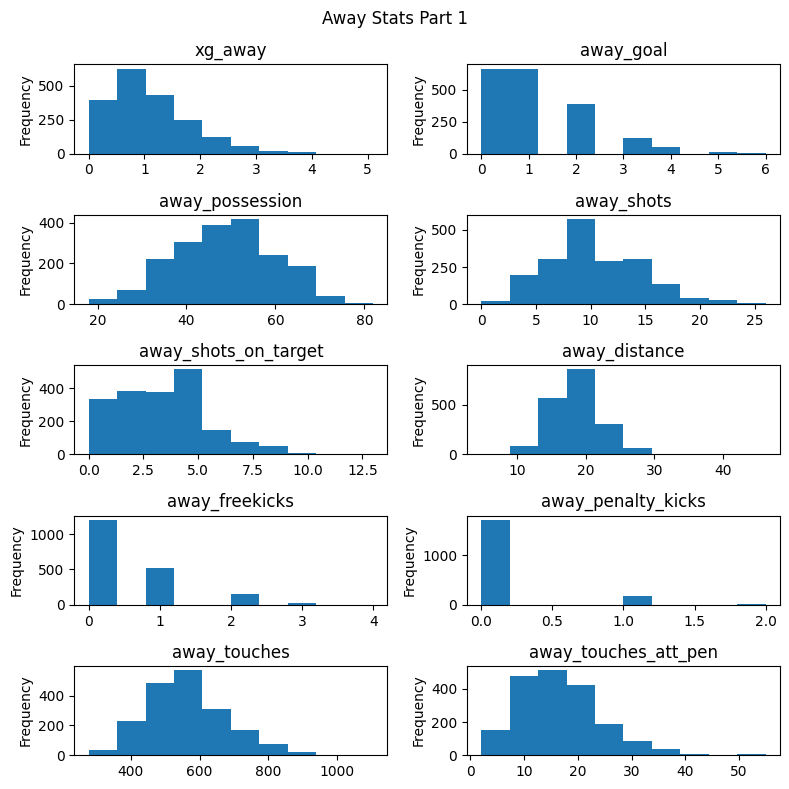

In [25]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_away'].plot.hist(ax =ax1[0,0], title = 'xg_away')
numerical_columns['away_goal'].plot.hist(ax =ax1[0,1], title = 'away_goal')
numerical_columns['away_possession'].plot.hist(ax =ax1[1,0], title = 'away_possession')
numerical_columns['away_shots'].plot.hist(ax =ax1[1,1], title = 'away_shots')
numerical_columns['away_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'away_shots_on_target')
numerical_columns['away_distance'].plot.hist(ax =ax1[2,1], title = 'away_distance')
numerical_columns['away_freekicks'].plot.hist(ax =ax1[3,0], title = 'away_freekicks')
numerical_columns['away_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'away_penalty_kicks')
numerical_columns['away_touches'].plot.hist(ax =ax1[4,0], title = 'away_touches')
numerical_columns['away_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'away_touches_att_pen')

plt.suptitle('Away Stats Part 1')
plt.tight_layout()
plt.show()

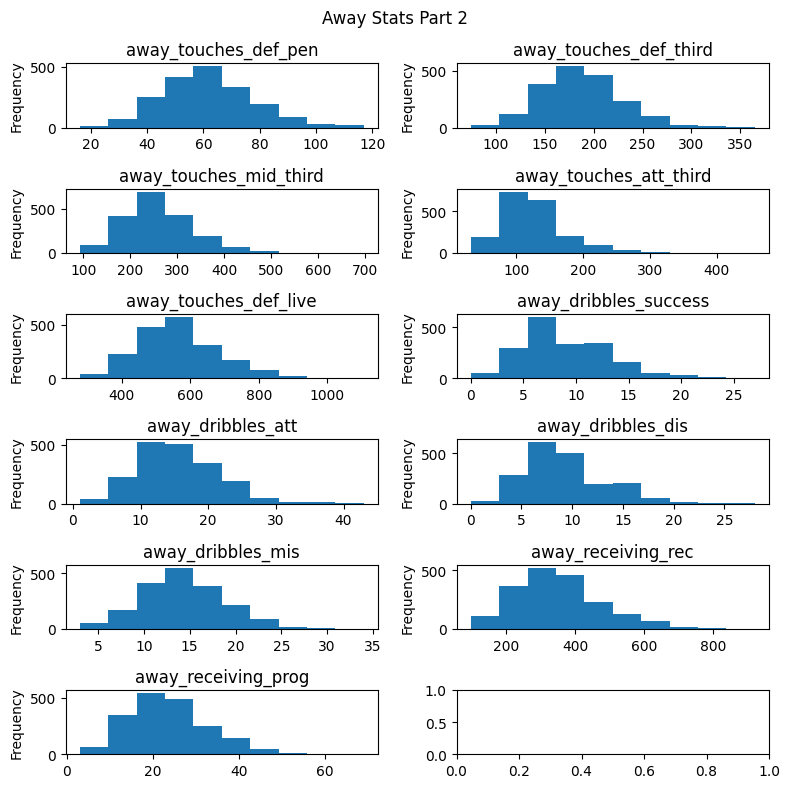

In [26]:
fig2, ax2 = plt.subplots(nrows=6, ncols= 2,figsize=(8, 8))
numerical_columns['away_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'away_touches_def_pen')
numerical_columns['away_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'away_touches_def_third')
numerical_columns['away_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'away_touches_mid_third')
numerical_columns['away_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'away_touches_att_third')
numerical_columns['away_touches_live'].plot.hist(ax =ax2[2,0], title = 'away_touches_def_live')
numerical_columns['away_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'away_dribbles_success')
numerical_columns['away_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'away_dribbles_att')
numerical_columns['away_dribbles_dis'].plot.hist(ax =ax2[3,1], title = 'away_dribbles_dis')
numerical_columns['away_dribbles_mis'].plot.hist(ax =ax2[4,0], title = 'away_dribbles_mis')
numerical_columns['away_receiving_rec'].plot.hist(ax =ax2[4,1], title = 'away_receiving_rec')
numerical_columns['away_receiving_prog'].plot.hist(ax =ax2[5,0], title = 'away_receiving_prog')

plt.suptitle('Away Stats Part 2')
plt.tight_layout()
plt.show()

Some of our numerical columns appear to have some skewed distributions. Potentially transforming them may help

In [27]:
#Check correlation
match_results_encode.columns.get_loc('match_result')

42

In [28]:
match_results_encode['match_result'][:15]

0     HW
1     HW
2     AW
3      D
4      D
5      D
6     HW
7     AW
8     HW
9     AW
10    HW
11    HW
12    AW
13    HW
14     D
Name: match_result, dtype: object

In [29]:
# Doing quick encoding 
match_correlation_df = match_results_encode.copy() 
match_correlation_df['match_result'] = match_correlation_df['match_result'].map({'D':0, 'HW':1, 'AW':2})
match_correlation_df['match_result'][:15]

0     1
1     1
2     2
3     0
4     0
5     0
6     1
7     2
8     1
9     2
10    1
11    1
12    2
13    1
14    0
Name: match_result, dtype: int64

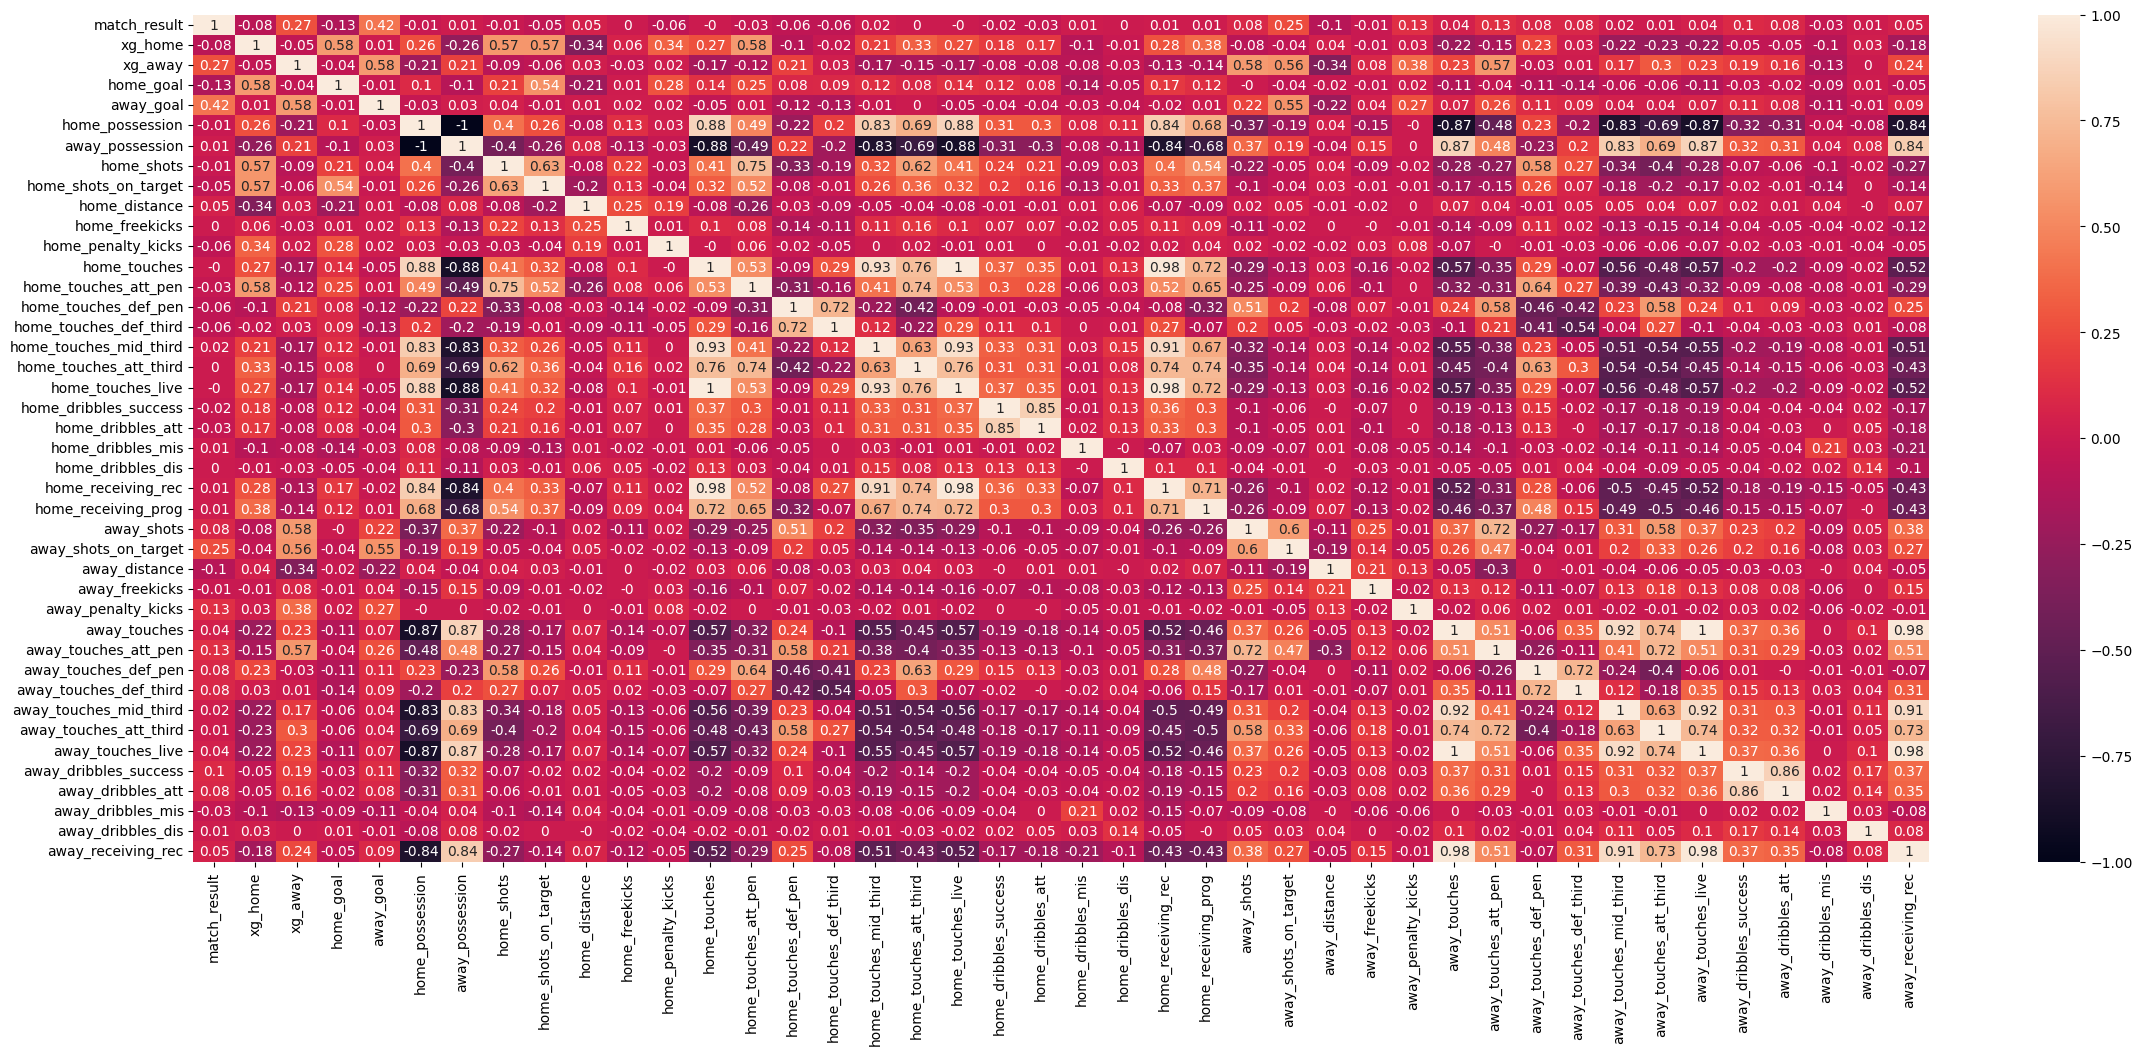

In [30]:
X1 = match_correlation_df.iloc[:,np.r_[42, 0:41]]
corrmatrix1 = X1.corr().round(2)
plt.figure(figsize = (28,11))
sns.heatmap(corrmatrix1, annot = True)
plt.show()

In [31]:
#Chi square test
category_cols = match_results_encode.select_dtypes(include=['object', 'uint8'])

In [32]:
category_cols

,match_result,home_captain_name_Aday,home_captain_name_Adri Embarba,home_captain_name_Adrián López,home_captain_name_Aitor Fernández,home_captain_name_Alberto Cifuentes,home_captain_name_Alberto García,home_captain_name_Alexander,home_captain_name_Alexis,home_captain_name_Alfonso Espino,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,HW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,AW,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1896,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1897,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1898,AW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
probs = []
for feature in category_cols:
    # print(feature)
    contingency = pd.crosstab(category_cols['match_result'], category_cols[feature])
    c, p, dof, expected = chi2_contingency(contingency)
    probs.append(f"match_result vs {feature}: {p}")
pprint(probs)

['match_result vs match_result: 0.0',
 'match_result vs home_captain_name_Aday: 0.6369134266334243',
 'match_result vs home_captain_name_Adri Embarba: 0.8382775431872875',
 'match_result vs home_captain_name_Adrián López: 0.15721978943504425',
 'match_result vs home_captain_name_Aitor Fernández: 0.2790476537736183',
 'match_result vs home_captain_name_Alberto Cifuentes: 0.2790476537736183',
 'match_result vs home_captain_name_Alberto García: 0.37338397883153845',
 'match_result vs home_captain_name_Alexander: 0.9277233160119299',
 'match_result vs home_captain_name_Alexis: 0.2790476537736183',
 'match_result vs home_captain_name_Alfonso Espino: 0.8604660273189545',
 'match_result vs home_captain_name_Ander Capa: 0.2790476537736183',
 'match_result vs home_captain_name_Ander Iturraspe: 0.22815272630486078',
 'match_result vs home_captain_name_Andrés Guardado: 0.16741736278092886',
 'match_result vs home_captain_name_Andrés Iniesta: 0.01036852441336306',
 'match_result vs home_captain_na

# Data Preparation

In [34]:
match_results_clean = match_results_encode.copy()

In [35]:
num_columns = numerical_columns.loc[:, :"away_receiving_prog"]

In [36]:
num_columns.columns

Index(['xg_home', 'xg_away', 'home_goal', 'away_goal', 'home_possession',
       'away_possession', 'home_shots', 'home_shots_on_target',
       'home_distance', 'home_freekicks', 'home_penalty_kicks', 'home_touches',
       'home_touches_att_pen', 'home_touches_def_pen',
       'home_touches_def_third', 'home_touches_mid_third',
       'home_touches_att_third', 'home_touches_live', 'home_dribbles_success',
       'home_dribbles_att', 'home_dribbles_mis', 'home_dribbles_dis',
       'home_receiving_rec', 'home_receiving_prog', 'away_shots',
       'away_shots_on_target', 'away_distance', 'away_freekicks',
       'away_penalty_kicks', 'away_touches', 'away_touches_att_pen',
       'away_touches_def_pen', 'away_touches_def_third',
       'away_touches_mid_third', 'away_touches_att_third', 'away_touches_live',
       'away_dribbles_success', 'away_dribbles_att', 'away_dribbles_mis',
       'away_dribbles_dis', 'away_receiving_rec', 'away_receiving_prog'],
      dtype='object')

In [37]:
scaler = MinMaxScaler()
match_results_clean[num_columns.columns] = scaler.fit_transform(match_results_clean[num_columns.columns])

In [38]:
pt = PowerTransformer()
match_results_clean[num_columns.columns] = pt.fit_transform(match_results_clean[num_columns.columns])

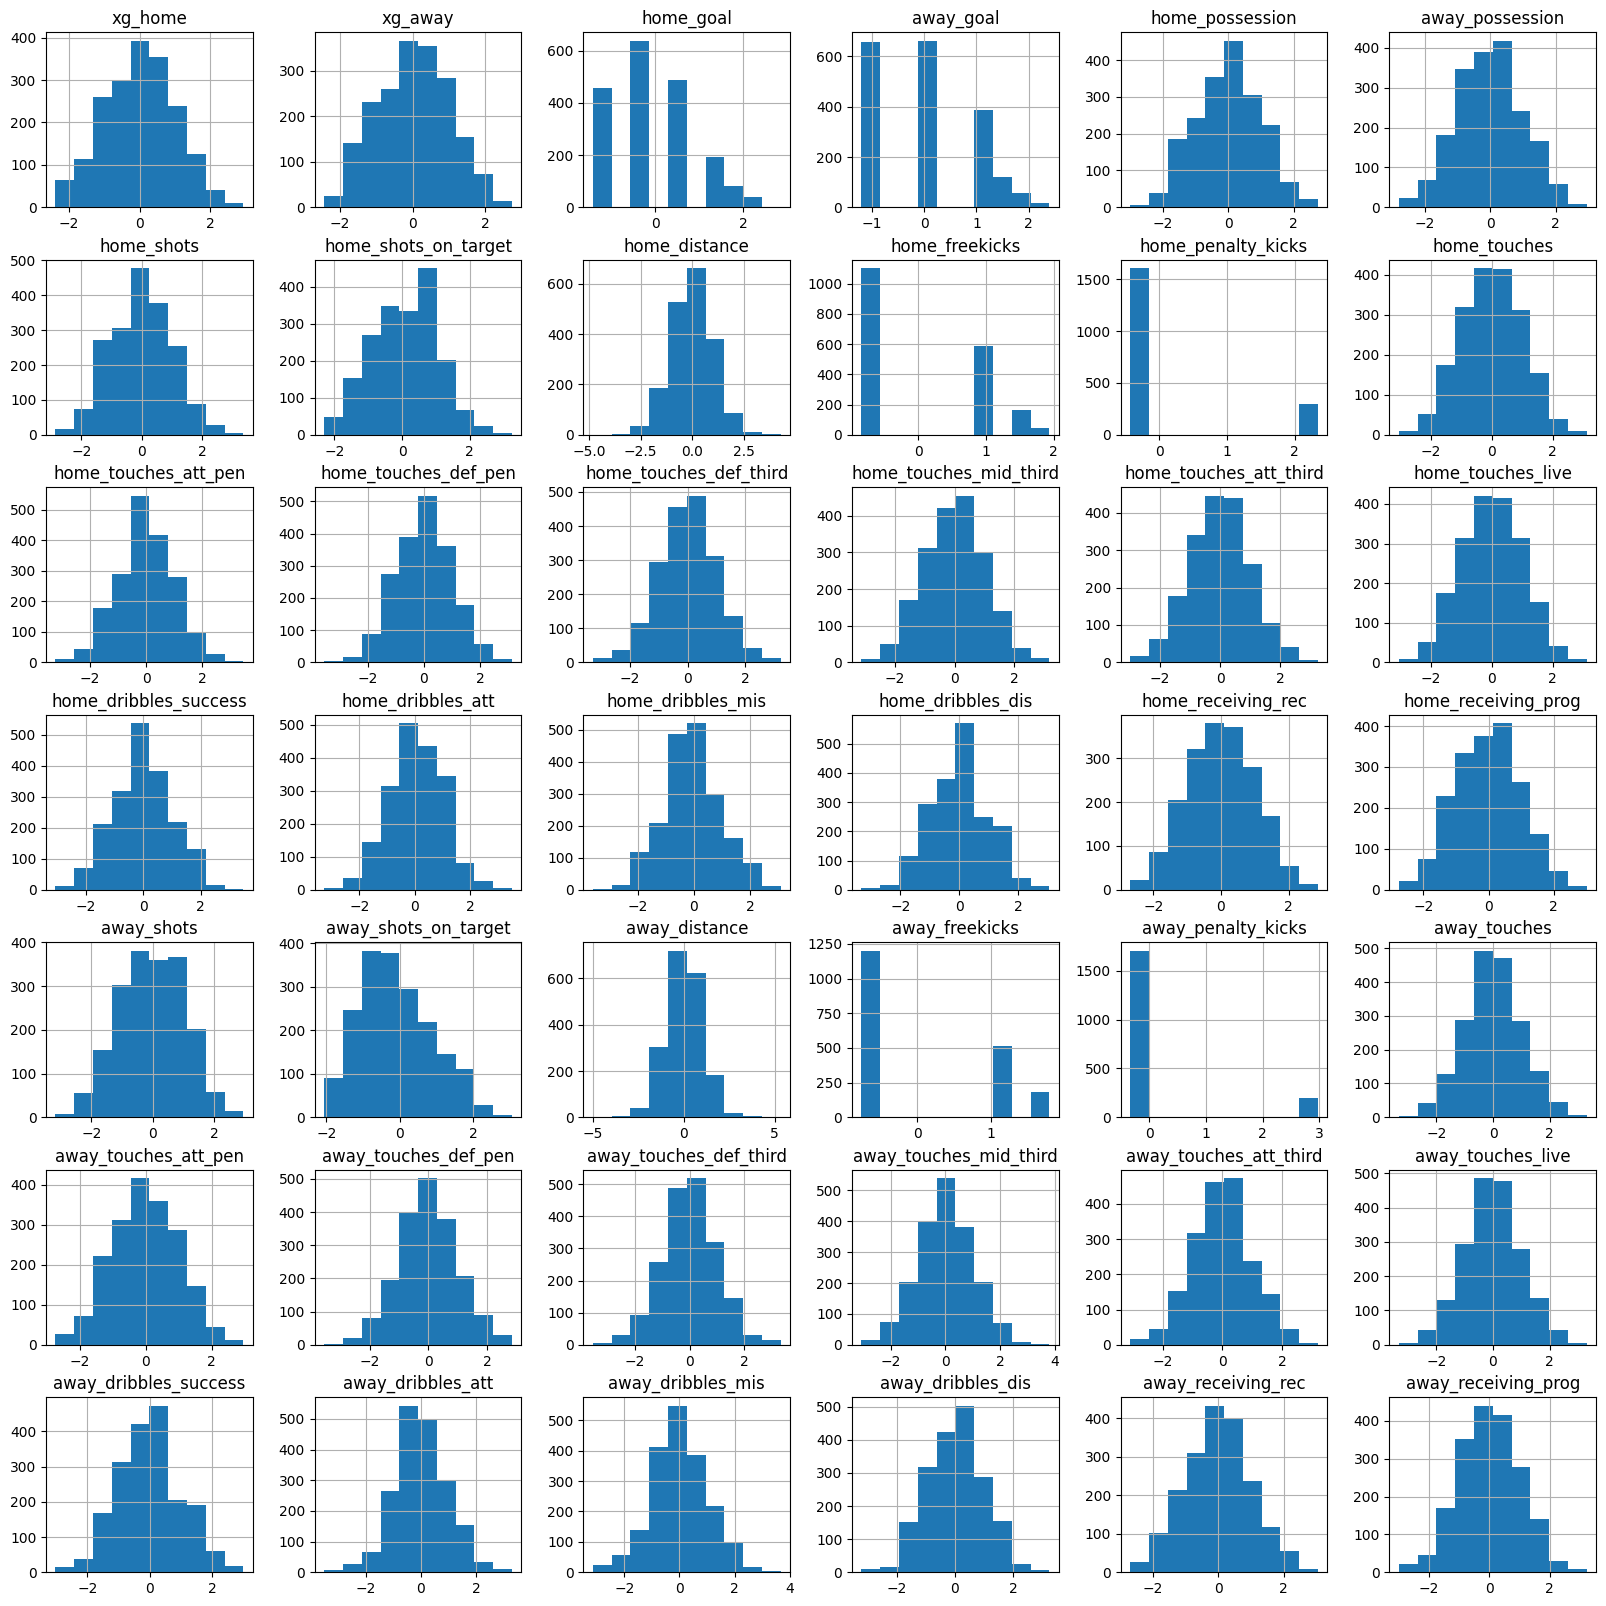

In [39]:
match_results_clean[num_columns.columns].hist(figsize=(20,20))
plt.show()

# Baseline Modeling

In [40]:
#Drop home_goal, away_goal, xg_home, and xg_away
X = match_results_encode.drop(['match_result', 'home_goal', 'away_goal', 'xg_home', 'xg_away'], axis =1)
y = match_results_encode['match_result']

In [41]:
#Have to map this for xgboost
y = y.map({"D" : 0, "HW": 1, "AW":2})

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 68)

## Decision Tree Classifier Baseline

In [48]:
clf = DecisionTreeClassifier(random_state = 67)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=67)

In [49]:
y_pred = clf.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.35      0.38        99
           1       0.59      0.67      0.62       171
           2       0.54      0.49      0.51       110

    accuracy                           0.53       380
   macro avg       0.51      0.50      0.51       380
weighted avg       0.53      0.53      0.53       380



In [51]:
print(confusion_matrix(y_test, y_pred))

[[ 35  45  19]
 [ 30 114  27]
 [ 21  35  54]]


In [52]:
accuracy_score(y_test, y_pred)

0.5342105263157895

## SVC Baseline

In [53]:
svc = SVC(random_state=5)

In [54]:
svc.fit(X_train, y_train)

SVC(random_state=5)

In [55]:
y_pred = svc.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.45      1.00      0.62       171
           2       0.00      0.00      0.00       110

    accuracy                           0.45       380
   macro avg       0.15      0.33      0.21       380
weighted avg       0.20      0.45      0.28       380



In [57]:
print(confusion_matrix(y_test, y_pred))

[[  0  99   0]
 [  0 171   0]
 [  0 110   0]]


In [58]:
accuracy_score(y_test, y_pred)

0.45

## RandomForest

In [59]:
rfc = RandomForestClassifier(random_state=5)

In [60]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=5)

In [61]:
y_pred = rfc.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.12      0.18        99
           1       0.55      0.85      0.67       171
           2       0.58      0.45      0.50       110

    accuracy                           0.54       380
   macro avg       0.50      0.47      0.45       380
weighted avg       0.51      0.54      0.49       380



In [63]:
print(confusion_matrix(y_test, y_pred))

[[ 12  68  19]
 [  9 145  17]
 [ 11  50  49]]


In [64]:
accuracy_score(y_test, y_pred)

0.5421052631578948

## XgBoostClassifer

In [65]:
xgb_cls = xgb.XGBClassifier(random_state = 5, n_jobs = 6)

In [66]:
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=6, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [67]:
y_pred = xgb_cls.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.29      0.34        99
           1       0.66      0.74      0.70       171
           2       0.61      0.63      0.62       110

    accuracy                           0.59       380
   macro avg       0.55      0.55      0.55       380
weighted avg       0.57      0.59      0.58       380



In [69]:
print(confusion_matrix(y_test, y_pred))

[[ 29  49  21]
 [ 20 127  24]
 [ 25  16  69]]


In [70]:
accuracy_score(y_test, y_pred)

0.5921052631578947

## AdaBoostClassifier

In [71]:
ada = AdaBoostClassifier(random_state=5)

In [72]:
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=5)

In [73]:
y_pred = ada.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        99
           1       0.69      0.73      0.71       171
           2       0.60      0.54      0.56       110

    accuracy                           0.58       380
   macro avg       0.56      0.55      0.55       380
weighted avg       0.58      0.58      0.58       380



In [75]:
print(confusion_matrix(y_test, y_pred))

[[ 38  38  23]
 [ 29 125  17]
 [ 34  17  59]]


In [76]:
accuracy_score(y_test, y_pred)

0.5842105263157895

## Gradient Boosting

In [77]:
grad_boost = GradientBoostingClassifier(random_state=5)

In [78]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=5)

In [79]:
y_pred = grad_boost.predict(X_test)

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.32      0.38        99
           1       0.66      0.74      0.70       171
           2       0.57      0.61      0.59       110

    accuracy                           0.59       380
   macro avg       0.56      0.56      0.56       380
weighted avg       0.58      0.59      0.58       380



In [81]:
print(confusion_matrix(y_test, y_pred))

[[ 32  39  28]
 [ 21 127  23]
 [ 18  25  67]]


In [82]:
accuracy_score(y_test, y_pred)

0.5947368421052631

# Tune the models

## RandomForest

In [83]:
rfc.get_params() # Random Forest

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [84]:
params_rf = {
    "n_estimators": [350, 375, 400,425,450],
    "criterion": ["gini", "entropy",],
    "max_features" : [None, 100, 200, 300, 400, 500],
    # "min_samples_split" :[3,4,5],
    # "min_samples_leaf": [2,3,4],
    # "max_leaf_nodes" : [5, 8, 10, 12],

}

In [85]:
# {'criterion': 'entropy', 'max_features': 520, 'n_estimators': 400} - 60% accuracy

clf_rf_tuned = HalvingGridSearchCV(
    estimator = rfc,
    param_grid=params_rf,
    cv = 5,
    n_jobs = 6,
    verbose = 6
)

In [86]:
start = time.time()
clf_rf_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 56
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 20
n_resources: 168
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 2
n_candidates: 7
n_resources: 504
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 1512
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(random_state=5), n_jobs=6,
                    param_grid={'criterion': ['gini', 'entropy'],
                                'max_features': [None, 100, 200, 300, 400, 500],
                                'n_estimators': [350, 375, 400, 425, 450]},
                    verbose=6)

In [87]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 464.32972240448 seconds


In [88]:
clf_rf_tuned.best_params_

{'criterion': 'entropy', 'max_features': 300, 'n_estimators': 400}

In [89]:
y_pred = clf_rf_tuned.predict(X_test)

In [90]:
confusion_matrix(y_test, y_pred)

array([[ 18,  51,  30],
       [ 13, 135,  23],
       [ 15,  28,  67]], dtype=int64)

In [91]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.39      0.18      0.25        99
           1       0.63      0.79      0.70       171
           2       0.56      0.61      0.58       110

    accuracy                           0.58       380
   macro avg       0.53      0.53      0.51       380
weighted avg       0.55      0.58      0.55       380



In [92]:
print(accuracy_score(y_test, y_pred))

0.5789473684210527


## Gradient Boosting tuned

In [93]:
grad_boost.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 5,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [94]:
params_gb = {
    "learning_rate": [0.075, 0.08, 0.085, 0.1],
    "n_estimators": [300, 350,400, 450,500],
    # "max_features": [None, 100, 200, 300, 400, 500, 546],
    "max_depth" : [4,6,7,8],
}

In [95]:
# {'learning_rate': 0.08, - 60.7% accuracy
#  'max_depth': 3,
#  'max_features': 500,
#  'n_estimators': 200}

clf_gb_tuned = HalvingGridSearchCV(
    estimator = grad_boost,
    param_grid=params_gb,
    cv = 5,
    n_jobs = 6,
    verbose = 6
)

In [96]:
start = time.time()
clf_gb_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 56
Fitting 5 folds for each of 80 candidates, totalling 400 fits
----------
iter: 1
n_candidates: 27
n_resources: 168
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 504
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 1512
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=GradientBoostingClassifier(random_state=5),
                    n_jobs=6,
                    param_grid={'learning_rate': [0.075, 0.08, 0.085, 0.1],
                                'max_depth': [4, 6, 7, 8],
                                'n_estimators': [300, 350, 400, 450, 500]},
                    verbose=6)

In [97]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 1245.195294380188 seconds


In [98]:
clf_gb_tuned.best_params_

{'learning_rate': 0.08, 'max_depth': 6, 'n_estimators': 500}

In [99]:
y_pred = clf_gb_tuned.predict(X_test)

In [100]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.45      0.37      0.41        99
           1       0.67      0.71      0.69       171
           2       0.59      0.61      0.60       110

    accuracy                           0.59       380
   macro avg       0.57      0.57      0.56       380
weighted avg       0.59      0.59      0.59       380



In [101]:
print(confusion_matrix(y_test,y_pred)) 

[[ 37  38  24]
 [ 26 122  23]
 [ 20  23  67]]


In [102]:
print(accuracy_score(y_test, y_pred))

0.5947368421052631


## XgBoost Classifier Tuned

In [103]:
xgb_cls.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 5,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [104]:
params_xgb = {
     "n_estimators": [190,200, 210, 225, 235, 250],
    "learning_rate" : [0.05, 0.053, 0.055],
    "max_depth" : [None, 3,4,5,6],
    
}

In [105]:
# {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 200} - 62.6% accuracy

clf_xgb_tuned = HalvingGridSearchCV(
    estimator = xgb_cls,
    param_grid=params_xgb,
    cv = 5,
    n_jobs = 6,
    verbose = 10
)

In [106]:
start = time.time()

clf_xgb_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 5
n_possible_iterations: 4
min_resources_: 30
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 90
n_resources: 30
Fitting 5 folds for each of 90 candidates, totalling 450 fits
----------
iter: 1
n_candidates: 30
n_resources: 90
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 10
n_resources: 270
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 3
n_candidates: 4
n_resources: 810
Fitting 5 folds for each of 4 candidates, totalling 20 fits


HalvingGridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.3000000...
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=6,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                            predictor='auto', ...),
                    n_jobs=6,
                    param_grid={'learning_rate': [0.05, 0.053, 0.055],
                                'max_depth': [None, 3, 4, 5, 6],
                                'n_estimators': [190, 200, 210, 225, 235, 250]},
                    verbose=10)

In [107]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 804.2489995956421 seconds


In [108]:
clf_xgb_tuned.best_params_

{'learning_rate': 0.053, 'max_depth': 3, 'n_estimators': 190}

In [109]:
y_pred = clf_xgb_tuned.predict(X_test)

In [110]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.40      0.22      0.29        99
           1       0.64      0.78      0.70       171
           2       0.58      0.60      0.59       110

    accuracy                           0.58       380
   macro avg       0.54      0.54      0.53       380
weighted avg       0.56      0.58      0.56       380



In [111]:
confusion_matrix(y_test, y_pred)

array([[ 22,  48,  29],
       [ 18, 134,  19],
       [ 15,  29,  66]], dtype=int64)

In [112]:
print(accuracy_score(y_test, y_pred))

0.5842105263157895


## AdaBoost Tuned

In [113]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 5}

In [114]:
params_ada = {
    "algorithm" : ["SAMME.R", "SAMME"],
    "n_estimators": [50, 75, 100],
    "learning_rate":[0.01, 0.05, 0.075, 0.1, 1]
}

In [115]:
# {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 80} - 57.8% accuracy

ada_tuned = HalvingGridSearchCV(
    estimator = ada,
    param_grid = params_ada,
    cv = 5,
    n_jobs = 6,
    verbose = 10
)

In [116]:
start = time.time()
ada_tuned.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 56
max_resources_: 1520
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 56
Fitting 5 folds for each of 30 candidates, totalling 150 fits
----------
iter: 1
n_candidates: 10
n_resources: 168
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 2
n_candidates: 4
n_resources: 504
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1512
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(estimator=AdaBoostClassifier(random_state=5), n_jobs=6,
                    param_grid={'algorithm': ['SAMME.R', 'SAMME'],
                                'learning_rate': [0.01, 0.05, 0.075, 0.1, 1],
                                'n_estimators': [50, 75, 100]},
                    verbose=10)

In [117]:
end = time.time()
print(f"Time taken to run: {end - start} seconds")

Time taken to run: 48.03601408004761 seconds


In [118]:
ada_tuned.best_params_

{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100}

In [119]:
y_pred = ada_tuned.predict(X_test)

In [120]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.38      0.39      0.39        99
           1       0.65      0.74      0.69       171
           2       0.67      0.52      0.58       110

    accuracy                           0.58       380
   macro avg       0.57      0.55      0.55       380
weighted avg       0.59      0.58      0.58       380



In [121]:
confusion_matrix(y_test, y_pred)

array([[ 39,  42,  18],
       [ 35, 126,  10],
       [ 28,  25,  57]], dtype=int64)

In [122]:
print(accuracy_score(y_test, y_pred))

0.5842105263157895


# Tuning Without GridSearch

## Random Forest

In [123]:
rfc = RandomForestClassifier(random_state = 5,
                             criterion = "entropy",
                             max_features = 250,
                             max_depth = 6,
                             min_samples_split = 25,
                             max_leaf_nodes = None,
                             min_samples_leaf = 1,
                             n_jobs = 6)

In [124]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 250,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 25,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 6,
 'oob_score': False,
 'random_state': 5,
 'verbose': 0,
 'warm_start': False}

In [125]:
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=250,
                       min_samples_split=25, n_jobs=6, random_state=5)

In [126]:
y_pred = rfc.predict(X_test)

In [127]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.21      0.60      0.31        35
           1       0.84      0.65      0.73       222
           2       0.64      0.57      0.60       123

    accuracy                           0.62       380
   macro avg       0.56      0.61      0.55       380
weighted avg       0.72      0.62      0.65       380



In [128]:
print(confusion_matrix(y_pred, y_test))

[[ 21   4  10]
 [ 48 144  30]
 [ 30  23  70]]


In [129]:
print(accuracy_score(y_pred, y_test))

0.618421052631579


## XGBoostClassifier

In [130]:
# xgb_cls = xgb.XGBClassifier(random_state = 5, 63.9% accuracy
#                            n_jobs = 6,
#                            learning_rate = 0.048,
#                             n_estimators = 200,
#                             colsample_bytree = 0.85
#                              gamma = 0.95
#                            )
xgb_cls = xgb.XGBClassifier(random_state = 5,
                           n_jobs = 6,
                           learning_rate = 0.048,
                            n_estimators = 200,
                            colsample_bytree = 0.85,
                            subsample = 1,
                            gamma = 0.95,
                            reg_lambda = 1,
                            reg_alpha = 0,
                            max_depth = 6,
                           )

In [131]:
xgb_cls.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.95, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.048, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [132]:
xgb_cls.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.85,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.95,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.048,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 5,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [133]:
y_pred = xgb_cls.predict(X_test)

In [134]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44        78
           1       0.78      0.69      0.73       195
           2       0.64      0.65      0.65       107

    accuracy                           0.64       380
   macro avg       0.60      0.61      0.61       380
weighted avg       0.66      0.64      0.65       380



In [135]:
print(confusion_matrix(y_pred, y_test))

[[ 39  19  20]
 [ 41 134  20]
 [ 19  18  70]]


In [136]:
print(accuracy_score(y_pred, y_test))

0.6394736842105263


## Gradient Boosting

In [137]:
# gbc = GradientBoostingClassifier(random_state=5, 
#                                  max_depth = 3,
#                                 learning_rate = 0.07,
#                                 n_estimators= 250,
#                                 max_features = 350) - 62.8% accuracy
gbc = GradientBoostingClassifier(random_state=5, 
                                 max_depth = 3,
                                learning_rate = 0.07,
                                n_estimators= 250,
                                max_features = 350,
                                min_samples_leaf = 1,
                                min_samples_split = 2)

In [138]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.07,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': 350,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_iter_no_change': None,
 'random_state': 5,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [139]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.07, max_features=350,
                           n_estimators=250, random_state=5)

In [140]:
y_pred = gbc.predict(X_test)

In [141]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        79
           1       0.77      0.71      0.74       186
           2       0.62      0.59      0.60       115

    accuracy                           0.63       380
   macro avg       0.59      0.60      0.59       380
weighted avg       0.65      0.63      0.64       380



In [142]:
print(confusion_matrix(y_pred, y_test))

[[ 39  19  21]
 [ 33 132  21]
 [ 27  20  68]]


In [143]:
print(accuracy_score(y_pred, y_test))

0.6289473684210526


## AdaBoostClassifier Tuning

In [144]:
ada = AdaBoostClassifier(random_state=5,
                        n_estimators = 150,
                        learning_rate = 0.065)

In [145]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.065,
 'n_estimators': 150,
 'random_state': 5}

In [146]:
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.065, n_estimators=150, random_state=5)

In [147]:
y_pred = ada.predict(X_test)

In [148]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.30      0.46      0.37        65
           1       0.83      0.62      0.71       229
           2       0.52      0.66      0.58        86

    accuracy                           0.60       380
   macro avg       0.55      0.58      0.55       380
weighted avg       0.67      0.60      0.62       380



In [149]:
print(confusion_matrix(y_pred, y_test))

[[ 30  16  19]
 [ 53 142  34]
 [ 16  13  57]]


In [150]:
print(accuracy_score(y_pred, y_test))

0.6026315789473684


## Final Models

## 1. XgBoost - Top Performer

In [152]:
xgb_cls_final = xgb.XGBClassifier(random_state = 5,
                           n_jobs = 6,
                           learning_rate = 0.048,
                            n_estimators = 200,
                            colsample_bytree = 0.85,
                            subsample = 1,
                            gamma = 0.95,
                            reg_lambda = 1,
                            reg_alpha = 0,
                            max_depth = 6,
                           )

In [153]:
xgb_cls_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.95, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.048, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=6,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [154]:
y_pred = xgb_cls_final.predict(X_test)

In [155]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.50      0.44        78
           1       0.78      0.69      0.73       195
           2       0.64      0.65      0.65       107

    accuracy                           0.64       380
   macro avg       0.60      0.61      0.61       380
weighted avg       0.66      0.64      0.65       380



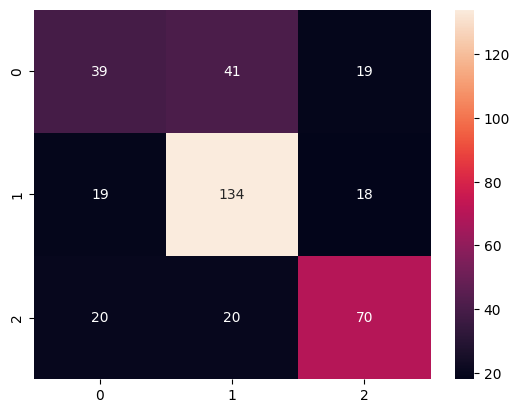

In [161]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

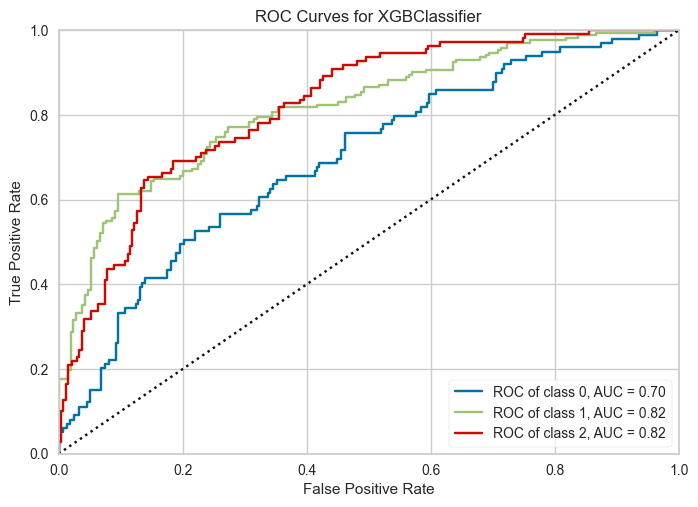

In [164]:
visualizer= ROCAUC(xgb_cls_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

# 2. Gradient Boosting Classifier Final

In [165]:
gbc_final = GradientBoostingClassifier(random_state=5, 
                                 max_depth = 3,
                                learning_rate = 0.07,
                                n_estimators= 250,
                                max_features = 350,
                                min_samples_leaf = 1,
                                min_samples_split = 2)

In [166]:
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.07, max_features=350,
                           n_estimators=250, random_state=5)

In [167]:
y_pred = gbc_final.predict(X_test)

In [168]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        79
           1       0.77      0.71      0.74       186
           2       0.62      0.59      0.60       115

    accuracy                           0.63       380
   macro avg       0.59      0.60      0.59       380
weighted avg       0.65      0.63      0.64       380



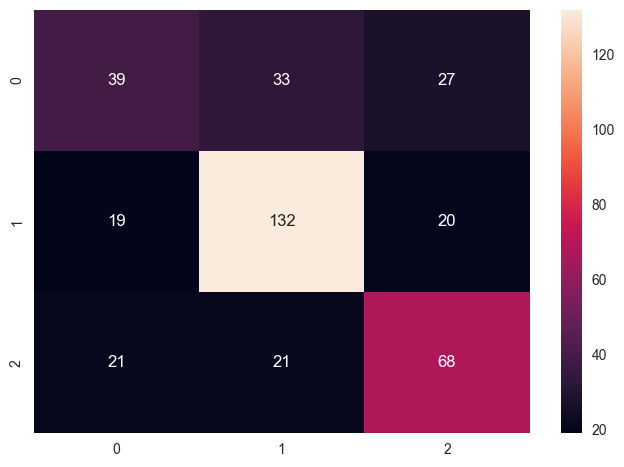

In [169]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

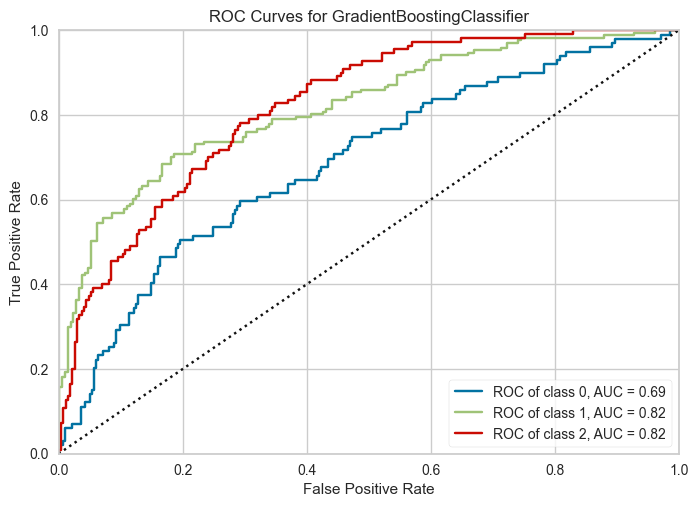

In [170]:
visualizer= ROCAUC(gbc_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

## 3. AdaBoost Classifer Final

In [171]:
ada_final = AdaBoostClassifier(random_state=5,
                        n_estimators = 150,
                        learning_rate = 0.065)

In [172]:
ada_final.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.065, n_estimators=150, random_state=5)

In [173]:
y_pred = ada_final.predict(X_test)

In [174]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.30      0.46      0.37        65
           1       0.83      0.62      0.71       229
           2       0.52      0.66      0.58        86

    accuracy                           0.60       380
   macro avg       0.55      0.58      0.55       380
weighted avg       0.67      0.60      0.62       380



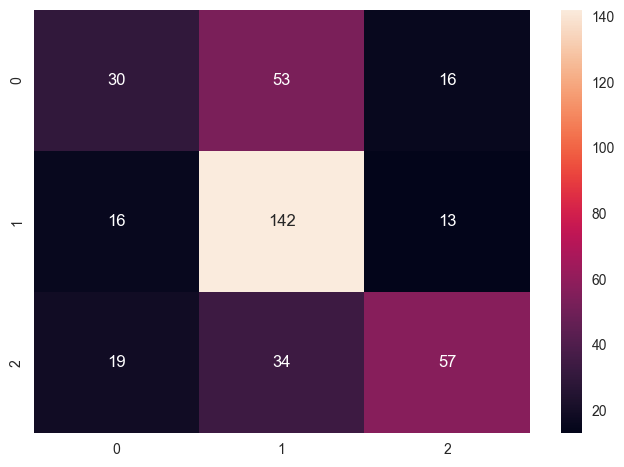

In [175]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

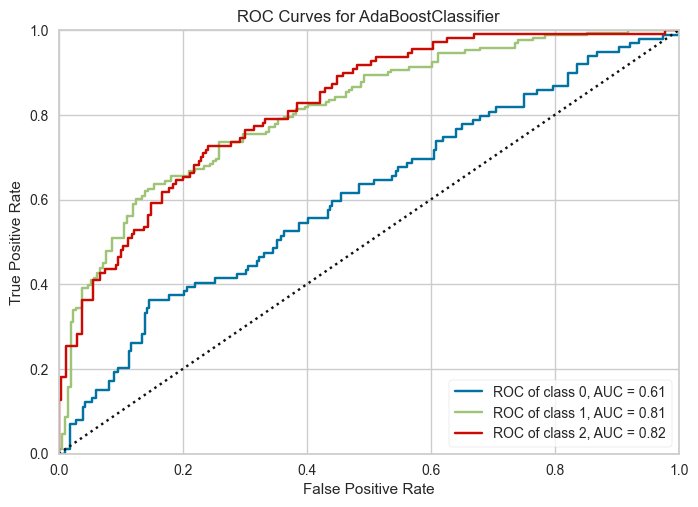

In [176]:
visualizer= ROCAUC(ada_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()

## 4. Random Forest Classifier Final

In [177]:
rfc_final = RandomForestClassifier(random_state = 5,
                             criterion = "entropy",
                             max_features = 250,
                             max_depth = 6,
                             min_samples_split = 25,
                             max_leaf_nodes = None,
                             min_samples_leaf = 1,
                             n_jobs = 6)

In [178]:
rfc_final.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=250,
                       min_samples_split=25, n_jobs=6, random_state=5)

In [179]:
y_pred = rfc_final.predict(X_test)

In [180]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.21      0.60      0.31        35
           1       0.84      0.65      0.73       222
           2       0.64      0.57      0.60       123

    accuracy                           0.62       380
   macro avg       0.56      0.61      0.55       380
weighted avg       0.72      0.62      0.65       380



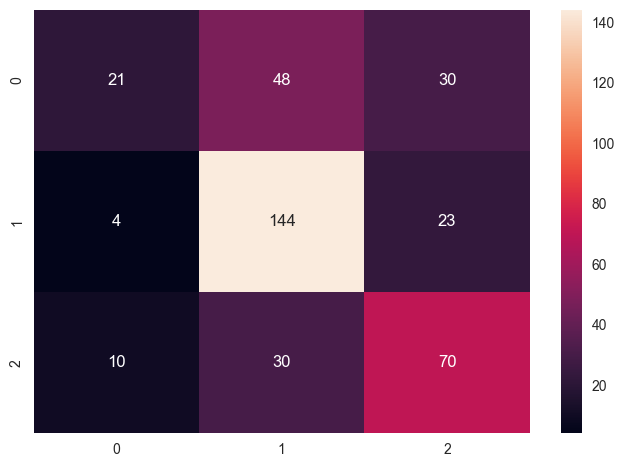

In [181]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = "d")
plt.show()

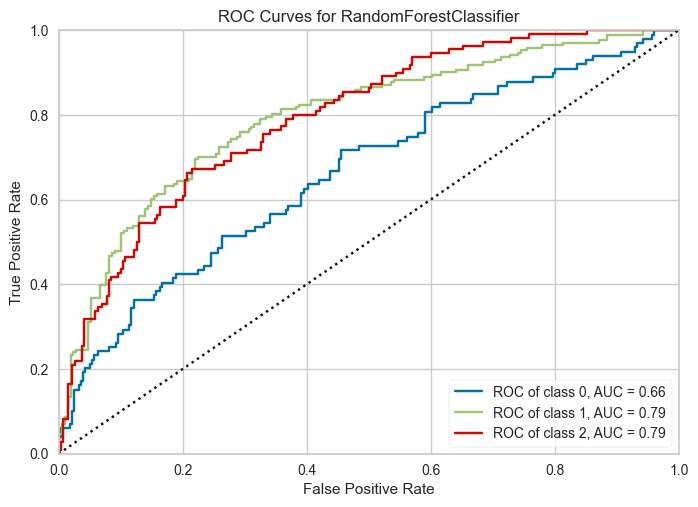

In [182]:
visualizer= ROCAUC(rfc_final, classes=["0", "1", "2"], micro = False, macro=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()
plt.show()